In [4]:
import numpy as np
import matplotlib.pyplot as plt
from urdf_parser_py.urdf import URDF
import os
import time
%matplotlib inline

In [5]:
URDF_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '/catbot_description/urdf/'
urdf_model     = URDF_DIR + 'catbot.urdf'\

urdf_str = open(urdf_model, 'r').read()
robot_urdf = URDF.from_xml_string(urdf_str)


CatBot Lab Context: This notebook supports the CatBot course and focuses on Robot state estimation.

# Robot state estimation

Based on [1]

___________________
[1] M. Bloesch, et al., “State estimation for legged robots - consistent fusion of leg kinematics and IMU,” in Proceedings of Robotics: Science and Systems, (Sydney, Australia), July 2012


http://www.roboticsproceedings.org/rss08/p03.pdf

Potentiometer provide access to the angular position of all joints. The corresponding measurement is assumed to be affected by discrete Gaussian noise:
\begin{equation}
\hat{\alpha} = \alpha + n_\alpha
\end{equation}


Based on the known leg kinematics, the location of each foot can be computed with respect to the main body. Due to erroneous calibration and possible errors in the kinematical model $F(·)$ of leg i, additive discrete Gaussian noise terms $n_{s,i}$ are included in the model:

\begin{equation}
s_i = F(\alpha) + n_{s,i}
\end{equation}

where $s_i$ represents the position of the feet $i$ from the center of the main
body and where $R_s$ is the
covariance matrix of $n_{s,i}$. Both, $s_i$ and $n_{s,i}$ are expressed
in the body fixed frame $B$.

The IMU measures the proper acceleration $f$ and the angular rate $\omega$ of the robot’s main body. The proper acceleration is related to the absolute acceleration a by:



# Continous time model

### Prediction state

\begin{equation}
\begin{cases}
\dot{\mathbf{p}}_b = \mathbf{v}_b    \\ 
\dot{\mathbf{v}}_b = R\mathbf{a}_b + \mathbf{\omega}_b     \\
\mathbf{\dot{p}}_i = \mathbf{\omega_{p,i}} \quad \forall i = 1,2,3,4
\end{cases}
\end{equation}

The measures from the IMU sensor are $R$ for the orientation and $\mathbf{a}_b$ for the acceleration without gravity. The white noise terms $\mathbf{\omega}_b$ and $\mathbf{\omega_{p,i}}$ characterize the noise in the accelerometer and any variability in the foot positions.

# Prediction state

\begin{equation}
\begin{cases}
\mathbf{p}_b(t) = \mathbf{p}_b(t-1) + \mathbf{v}_b(t-1) dt + R\mathbf{a}_b(t-1)\frac{dt^2}{2}   \\ 
\mathbf{v}_b(t) = \mathbf{v}_b(t-1) +  R\mathbf{a}_b(t-1) dt     \\
\mathbf{p}_i(t) = \mathbf{p}_i(t-1) \quad \forall i = 1,2,3,4
\end{cases}
\end{equation}

which in matrix format for the state vector $x = (\mathbf{p}_b, \mathbf{v}_b, \mathbf{p}_1, \mathbf{p}_2, \mathbf{p}_3, \mathbf{p}_4)^T$ is:

\begin{equation}
x(t+1) = Ax(t) + Bu(t)
\end{equation}

which expanded is:

\begin{equation}
\begin{pmatrix}
\mathbf{p}_b(t) \\
\mathbf{v}_b(t) \\
\mathbf{p}_1(t) \\ 
\mathbf{p}_2(t) \\
\mathbf{p}_3(t) \\
\mathbf{p}_4(t)
\end{pmatrix} = 
\begin{pmatrix}
I_{3x3} & I_{3x3} dt & 0 & 0 & 0 & 0 \\
0 & I_{3x3}  & 0 & 0 & 0 & 0 \\
0 & 0  & I_{3x3} & 0 & 0 & 0 \\
0 & 0  & 0 & I_{3x3} & 0 & 0 \\
0 & 0  & 0 & 0 & I_{3x3} & 0 \\
0 & 0  & 0 & 0 & 0 & I_{3x3} 
\end{pmatrix}
\begin{pmatrix}
\mathbf{p}_b(t-1) \\
\mathbf{v}_b(t-1) \\
\mathbf{p}_1(t-1) \\ 
\mathbf{p}_2(t-1) \\
\mathbf{p}_3(t-1) \\
\mathbf{p}_4(t-1)
\end{pmatrix}
+ 
\begin{pmatrix}
I_{3x3}\frac{dt^2}{2}\\
I_{3x3}dt \\
0 \\ 
0 \\
0 \\
0
\end{pmatrix}R\mathbf{a}_b(t-1)
\end{equation}

The discrete process noise covariance matrix $Q_k$ is:

\begin{equation}
Q_f = 
\begin{pmatrix}
\frac{dt^3}{3}Q_a    & \frac{dt^2}{2}Q_a  & 0 & 0 & 0 & 0 \\
\frac{dt^2}{2}Q_a    & dtQ_a              & 0 & 0 & 0 & 0 \\
0                                   & 0                                & dtR^T Q_{p,1} R & 0 & 0 & 0 \\
0                                   & 0                                & 0 & dtR^T Q_{p,2} R & 0 & 0 \\
0                                   & 0                                & 0 & 0 & dtR^T Q_{p,3} R & 0 \\
0                                   & 0                                & 0 & 0 & 0 & dtR^T Q_{p,4} R \\
\end{pmatrix}
\end{equation}

where

\begin{equation}
Q_{p,i} = 
\begin{pmatrix}
w_{p,i,x} & 0         & 0 \\
0         & w_{p,i,y} & 0 \\
0         & 0         & w_{p,i,z} 
\end{pmatrix}
\end{equation}

While in principle the foot contacts are assumed to remain stationary, the covariances $Q_{p,i}$ are added to the absolute foot positions in order to handle a certain amount of foot slippage. It is described in the body frame which allows tuning the magnitude of the noise terms in the different directions relative to the quadruped
orientation. Furthermore, the noise parameter of a certain foothold is set to infinity (or to a very large value) whenever it has no ground contact. This enables the corresponding foothold to relocate and reset its position estimate when it regains ground contact, whereby the old foothold position is dropped from the estimation process.

By linearly combining two Gaussian distributions the Kalman Filter stipulates the following a priori estimate of the covariance matrix at the timestep $t+1$:

\begin{equation}
P(t) = AP(t-1)A^T + Q_k
\end{equation}

In [4]:
def getRotationMatrix(euler_ang):
    [roll, pit, yaw] = np.array(euler_ang)
    
    Rx = np.array([[1,            0,              0,            ],
                   [0,            np.cos(roll),   -np.sin(roll) ],
                   [0,            np.sin(roll),   np.cos(roll) ]])
    
    Ry = np.array([[np.cos(yaw),  0,              np.sin(yaw) ],
                   [0,            1,              0,          ],
                   [-np.sin(yaw), 0,              np.cos(yaw)]])
    
    
    Rz = np.array([[np.cos(pit), -np.sin(pit),   0],
                   [np.sin(pit),  np.cos(pit),   0],
                   [0,            0,             1]])

    Rxyz = np.dot(Rz,Ry).dot(Rx)
    
    return Rxyz


def get_Q_feet(stance = True):
    if stance:
        return 0.001 * np.eye(3)    # This is not error from encoders, but error for slipping feet
    else:
        return 1000000 * np.eye(3)
    
    

def predictState(x, P, dt, euler_angs, lin_acc, p1_stance = True, p2_stance = True, p3_stance = True, p4_stance = True):
    I = np.eye(3)
    O = np.zeros([3,3])
    
    
    A = np.vstack([    np.hstack([I, I*dt, O, O, O, O]), 
                       np.hstack([O, I,    O, O, O, O]),
                       np.hstack([O, O,    I, O, O, O]),
                       np.hstack([O, O,    O, I, O, O]),
                       np.hstack([O, O,    O, O, I, O]),
                       np.hstack([O, O,    O, O, O, I]),
                  ])
    
    B = np.vstack([ I*(dt**2)/2, 
                    I*dt,
                    O,
                    O,
                    O,
                    O])
    
    print(A.shape, B.shape)
    
    R   = getRotationMatrix(euler_angs)
    R_T = R.T
    u = R.dot(lin_acc)
    
    x_ = A.dot(x) + B.dot(u)
    
    
    
    
    
    Q_acc = 0.3*np.eye(3)
    Q_p1  = get_Q_feet(p1_stance)
    Q_p2  = get_Q_feet(p2_stance)
    Q_p3  = get_Q_feet(p3_stance)
    Q_p4  = get_Q_feet(p4_stance)

    Q = np.vstack([   np.hstack([ Q_acc*(dt**3)/3, Q_acc*(dt**2)/2, O, O, O, O   ]),
                      np.hstack([ Q_acc*(dt**2)/2, Q_acc*dt       , O, O, O, O   ]),
                      np.hstack([ O              , O              , dt*R_T.dot(Q_p1).dot(R), O, O, O   ]),
                      np.hstack([ O              , O              , O, dt*R_T.dot(Q_p2).dot(R), O, O   ]),
                      np.hstack([ O              , O              , O, O, dt*R_T.dot(Q_p3).dot(R), O   ]),
                      np.hstack([ O              , O              , O, O, O, dt*R_T.dot(Q_p4).dot(R)   ]),
                  ])
    
    P_ = A.dot(P).dot(A.T) + Q
    return x_, P_













x = np.zeros(18)
P = np.zeros([18,18])
dt = 1
euler_angs = [0,0,0]
lin_acc = [0,1,0]

x, P = predictState(x, P,  dt, euler_angs, lin_acc)
print(x)
print("")
print(P)

((18, 18), (18, 3))
[0.  0.5 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]

[[0.1   0.    0.    0.15  0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.   ]
 [0.    0.1   0.    0.    0.15  0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.1   0.    0.    0.15  0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.   ]
 [0.15  0.    0.    0.3   0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.   ]
 [0.    0.15  0.    0.    0.3   0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.15  0.    0.    0.3   0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.   

## Update state 

The measurement residual, also called
innovation, is the difference between actual measurements and
their predicted value. Leg kinematics provide measurements of the relative
position vector between each foot and the body to dedrift estimates $\mathbf{p}_b$,
$\mathbf{v}_b$, and $\mathbf{p}_i$ for each foot.

Letting $\mathbf{p}_{rel}(\mathbf{q}_i, R)$ denote the relative foot position as computed
by kinematics, a measurement residual is generated:

\begin{equation}
y_{p,i} =  - \mathbf{p}_{rel}(\mathbf{q}_i(t), R(t)) + \Big(\mathbf{p}_i(t) - \mathbf{p}_b(t)\Big)
\end{equation}


Similarly, the velocity of the foot relative to the body can be computed from the leg angles, velocities, and the body orientation and angular velocity. This computation is denoted as
$\dot{\mathbf{p}}_{rel}(\mathbf{q}_i, \mathbf{\dot{q}}_i, \mathbf{R}, \mathbf{\omega}_b)$. Under the assumption that each foot is fixed, this provides an associated measurement residual


\begin{equation}
y_{v,i} =  - \dot{\mathbf{p}}_{rel}(\mathbf{q}_i, \mathbf{\dot{q}}_i, \mathbf{R}, \mathbf{\omega}_b) - \mathbf{v}_b 
\end{equation}


The measurement residual is given by:

\begin{equation}
y(t) = z(t) - H x(t)
\end{equation}

so that

\begin{equation}
y(t) = 
\begin{pmatrix}
- \mathbf{p}_{rel}(\mathbf{q}_1, R) \\
- \mathbf{p}_{rel}(\mathbf{q}_2, R) \\
- \mathbf{p}_{rel}(\mathbf{q}_3, R) \\
- \mathbf{p}_{rel}(\mathbf{q}_4, R) \\
- \dot{\mathbf{p}}_{rel}(\mathbf{q}_1, \mathbf{\dot{q}}_1, \mathbf{R}, \mathbf{\omega}_b) \\
- \dot{\mathbf{p}}_{rel}(\mathbf{q}_2, \mathbf{\dot{q}}_2, \mathbf{R}, \mathbf{\omega}_b) \\
- \dot{\mathbf{p}}_{rel}(\mathbf{q}_3, \mathbf{\dot{q}}_3, \mathbf{R}, \mathbf{\omega}_b) \\
- \dot{\mathbf{p}}_{rel}(\mathbf{q}_4, \mathbf{\dot{q}}_4, \mathbf{R}, \mathbf{\omega}_b) \\
-h_1 \\
-h_2 \\
-h_3 \\
-h_4
\end{pmatrix} - 
\begin{pmatrix}
I_{3x3} &  0       & -I_{3x3}  &  0  &  0  &  0 \\
I_{3x3} &  0       &  0  & -I_{3x3}  &  0  &  0 \\
I_{3x3} &  0       &  0  &  0  & -I_{3x3}  &  0 \\
I_{3x3} &  0       &  0  &  0  &  0  & -I_{3x3} \\
0       & -I_{3x3} &  0  &  0  &  0  &  0 \\
0       & -I_{3x3} &  0  &  0  &  0  &  0 \\
0       & -I_{3x3} &  0  &  0  &  0  &  0 \\
0       & -I_{3x3} &  0  &  0  &  0  &  0 \\
0       &  0       &  -[0,0,1] & 0 & 0 & 0 \\
0       &  0       & 0 & -[0,0,1] & 0 & 0 \\
0       &  0       & 0 & 0 & -[0,0,1] & 0 \\
0       &  0       & 0 & 0 & 0 & -[0,0,1] \\
\end{pmatrix}
\begin{pmatrix}
\mathbf{p}_b(t) \\
\mathbf{v}_b(t) \\
\mathbf{p}_1(t) \\ 
\mathbf{p}_2(t) \\
\mathbf{p}_3(t) \\
\mathbf{p}_4(t)
\end{pmatrix}
\end{equation}


Then the update state is given by:

\begin{equation}
\begin{cases}
y(t) = z(t) - Hx(t) \\
K(t) = P(t)H^T\Big(HP(t)H^T  + R(t)\Big)^{-1} \\
x(t) = x(t) + K(t)y(t) \\
P(t) = \Big(I - K(t)H\Big)P(t)
\end{cases}
\end{equation}


In [9]:
def updateState(x, P, z, R):
    I = np.eye(3)
    O = np.zeros([3,3])
    
    k = np.array([0,0,1])
    O_ = np.array([0,0,0])
    
    H = np.vstack([   np.hstack([ I,  O, -I,  O,  O,  O  ]),
                      np.hstack([ I,  O,  O, -I,  O,  O  ]),
                      np.hstack([ I,  O,  O,  O, -I,  O  ]),
                      np.hstack([ I,  O,  O,  O,  O, -I  ]),
                      np.hstack([ O, -I,  O,  O,  O,  O  ]),
                      np.hstack([ O, -I,  O,  O,  O,  O  ]),
                      np.hstack([ O, -I,  O,  O,  O,  O  ]),
                      np.hstack([ O, -I,  O,  O,  O,  O  ]),
                      np.hstack([ O_, O_, -k, O_, O_, O_  ]),
                      np.hstack([ O_, O_, O_, -k, O_, O_  ]),
                      np.hstack([ O_, O_, O_, O_, -k, O_  ]),
                      np.hstack([ O_, O_, O_, O_, O_, -k  ]),
                  ])
    
    
    y = z - H.dot(x)
    K = P.dot(H.T).dot(  np.linalg.inv(  H.dot(P).dot(H.T) + R  ))
    x_ =  x + K.dot(y)
    
    P_ = (  np.eye(P.shape[0]) - K.dot(H)  ).dot(P)
    return x_, P_
    
    
updateState(x, P, np.ones(28), 0.01*np.eye(28))

(array([ 0.85499964,  0.85540019,  0.77391996, -0.92637099, -0.91828709,
        -0.9302942 , -0.01318185, -0.01314544, -0.10217334, -0.01318185,
        -0.01314544, -0.10217334, -0.01318185, -0.01314544, -0.10217334,
        -0.01318185, -0.01314544, -0.10217334]),
 array([[2.48343165e-03, 0.00000000e+00, 0.00000000e+00, 1.20166048e-04,
         0.00000000e+00, 0.00000000e+00, 2.25766514e-04, 0.00000000e+00,
         0.00000000e+00, 2.25766514e-04, 0.00000000e+00, 0.00000000e+00,
         2.25766514e-04, 0.00000000e+00, 0.00000000e+00, 2.25766514e-04,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.48343165e-03, 0.00000000e+00, 0.00000000e+00,
         1.20166048e-04, 0.00000000e+00, 0.00000000e+00, 2.25766514e-04,
         0.00000000e+00, 0.00000000e+00, 2.25766514e-04, 0.00000000e+00,
         0.00000000e+00, 2.25766514e-04, 0.00000000e+00, 0.00000000e+00,
         2.25766514e-04, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.46488206e-03, 0.00000

# Get feet position from kinematic model

In [49]:
def getTransform(pos, euler_ang):
    [x,y,z]          = pos
    [roll, pit, yaw] = np.array(euler_ang)
    
    Rx = np.array([[1,            0,              0,             0],
                   [0,            np.cos(roll),   -np.sin(roll), 0],
                   [0,            np.sin(roll),   np.cos(roll),  0],
                   [0,            0,              0,             1]])
    
    Ry = np.array([[np.cos(yaw),  0,              np.sin(yaw),   0],
                   [0,            1,              0,             0],
                   [-np.sin(yaw), 0,              np.cos(yaw),   0],
                   [0,            0,              0,             1]])
    
    
    Rz = np.array([[np.cos(pit), -np.sin(pit),   0,             0],
                   [np.sin(pit),  np.cos(pit),   0,             0],
                   [0,            0,             1,             0],
                   [0,            0,             0,             1]])
    
    T_pos = np.array([[1, 0, 0, x],
                      [0, 1, 0, y],
                      [0, 0, 1, z],
                      [0, 0, 0, 1]])
    
    Rxyz = np.dot(Rz,Ry).dot(Rx)
    
    return T_pos.dot(Rxyz)


def getJointTransforms(robot_urdf, leg, angles):
    tf_joints = {}

    for joint in robot_urdf.joints:
        if leg in joint.name:
            pos       = np.array(joint.origin.xyz)
            euler_ang = np.zeros(3)
            
            if joint.name == '{:s}_ref'.format(leg):
                pos = np.array( joint.origin.xyz, dtype = 'float32' )
                tf_joints['ref'] = getTransform(pos, euler_ang)

            if 'hip1' in joint.name:
                euler_ang[0] = angles[0]
                tf_joints['hip1'] = getTransform(pos, euler_ang)
            
            if 'hip2' in joint.name:
                euler_ang[2] = angles[1]
                tf_joints['hip2'] = getTransform(pos, euler_ang)
                
            if 'knee' in joint.name:
                euler_ang[2] = angles[2]                
                tf_joints['knee'] = getTransform(pos, euler_ang)
            if 'feet' in joint.name:
                
                tf_joints['feet'] = getTransform(pos, euler_ang)
        
    return tf_joints


tf_joints = getJointTransforms(robot_urdf, 'fl', [0,0,0])
for joint in tf_joints:
    print(joint)
    print(tf_joints[joint])
    print("")

feet
[[ 1.       0.       0.       0.     ]
 [ 0.       1.       0.      -0.01451]
 [ 0.       0.       1.      -0.10938]
 [ 0.       0.       0.       1.     ]]

hip1
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

knee
[[ 1.       0.       0.       0.     ]
 [ 0.       1.       0.      -0.00436]
 [ 0.       0.       1.      -0.11335]
 [ 0.       0.       0.       1.     ]]

ref
[[1.      0.      0.      0.10136]
 [0.      1.      0.      0.05355]
 [0.      0.      1.      0.     ]
 [0.      0.      0.      1.     ]]

hip2
[[1.    0.    0.    0.   ]
 [0.    1.    0.    0.042]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    1.   ]]



In [44]:
def getLegPos(robot_urdf, leg, base_euler_angs, angles):
    tf_joints = getJointTransforms(robot_urdf, leg, angles)
        
    initial_pose = getTransform([0,0,0], base_euler_angs)
    pose_ref     = initial_pose.dot(tf_joints['ref'])
    pose_hip     = pose_ref.dot(tf_joints['hip1'])
    pose_femur   = pose_hip.dot(tf_joints['hip2'])
    pose_tibia   = pose_femur.dot(tf_joints['knee'])
    pose_feet    = pose_tibia.dot(tf_joints['feet'])
    
    pos_feet     = np.array([pose_feet[0, 3],  pose_feet[1, 3],  pose_feet[2, 3]])
    return pos_feet
    
getLegPos(robot_urdf, 'fl', [0.1,0.3,5], [0.3,0.1,0.2])

0.00138401985168


array([0.13878132, 0.20957171, 0.00265212])

# Kinematic model

In [59]:
import sympy as sp

theta0 = sp.Symbol('alpha_0')
theta1 = sp.Symbol('alpha_1')
theta2 = sp.Symbol('alpha_2')


roll = sp.Symbol('roll')
pit = sp.Symbol('pitch')
yaw = sp.Symbol('yaw')


In [60]:
def getTransform(pos, euler_ang):
    [x,y,z]          = pos
    [roll, pit, yaw] = np.array(euler_ang)
    
    Rx = sp.Matrix([[1,            0,              0,             0],
                   [0,            sp.cos(roll),   -sp.sin(roll), 0],
                   [0,            sp.sin(roll),   sp.cos(roll),  0],
                   [0,            0,              0,             1]])
    
    Ry = sp.Matrix([[sp.cos(yaw),  0,              sp.sin(yaw),   0],
                   [0,            1,              0,             0],
                   [-sp.sin(yaw), 0,              sp.cos(yaw),   0],
                   [0,            0,              0,             1]])
    
    
    Rz = sp.Matrix([[sp.cos(pit), -sp.sin(pit),   0,             0],
                   [sp.sin(pit),  sp.cos(pit),   0,             0],
                   [0,            0,             1,             0],
                   [0,            0,             0,             1]])
    
    T_pos = sp.Matrix([[1, 0, 0, x],
                      [0, 1, 0, y],
                      [0, 0, 1, z],
                      [0, 0, 0, 1]])
    
    Rxyz = Rz*Ry*Rx
    
    return T_pos * Rxyz


def getJointTransforms(robot_urdf, leg, angles):
    tf_joints = {}

    for joint in robot_urdf.joints:
        if leg in joint.name:
            pos       = np.array(joint.origin.xyz)
            euler_ang = [0,0,0]
            
            if joint.name == '{:s}_ref'.format(leg):
                pos = np.array( joint.origin.xyz, dtype = 'float32' )
                tf_joints['ref'] = getTransform(pos, euler_ang)
                
            if  joint.name == 'hip1_{:s}'.format(leg):
                euler_ang[0] = angles[0]
                tf_joints['hip1'] = getTransform(pos, euler_ang)
            
            if joint.name == 'hip2_{:s}'.format(leg):
                euler_ang[2] = angles[1]
                tf_joints['hip2'] = getTransform(pos, euler_ang)
                
            if joint.name == 'knee_{:s}'.format(leg):
                euler_ang[2] = angles[2]                
                tf_joints['knee'] = getTransform(pos, euler_ang)
            if 'feet' in joint.name:
                tf_joints['feet'] = getTransform(pos, euler_ang)
    
    return tf_joints

tf_joints = getJointTransforms(robot_urdf, 'fl', [theta0, theta1, theta2])
F_fl = tf_joints['ref']*tf_joints['hip1']*tf_joints['hip2']*tf_joints['knee']*tf_joints['feet']

tf_joints = getJointTransforms(robot_urdf, 'fr', [theta0, theta1, theta2])
F_fr = tf_joints['ref']*tf_joints['hip1']*tf_joints['hip2']*tf_joints['knee']*tf_joints['feet']

tf_joints = getJointTransforms(robot_urdf, 'bl', [theta0, theta1, theta2])
F_bl = tf_joints['ref']*tf_joints['hip1']*tf_joints['hip2']*tf_joints['knee']*tf_joints['feet']


tf_joints = getJointTransforms(robot_urdf, 'br', [theta0, theta1, theta2])
F_br = tf_joints['ref']*tf_joints['hip1']*tf_joints['hip2']*tf_joints['knee']*tf_joints['feet']


base_rot_tf = getTransform([0,0,0], [roll, pit, yaw])
base_rot_tf

Matrix([
[cos(pitch)*cos(yaw), -sin(pitch)*cos(roll) + sin(roll)*sin(yaw)*cos(pitch), sin(pitch)*sin(roll) + sin(yaw)*cos(pitch)*cos(roll), 0],
[sin(pitch)*cos(yaw),  sin(pitch)*sin(roll)*sin(yaw) + cos(pitch)*cos(roll), sin(pitch)*sin(yaw)*cos(roll) - sin(roll)*cos(pitch), 0],
[          -sin(yaw),                                    sin(roll)*cos(yaw),                                   cos(roll)*cos(yaw), 0],
[                  0,                                                     0,                                                    0, 1]])

In [41]:
Feet_pos_fl = sp.simplify(F_fl[:3,3])
Feet_pos_fr = sp.simplify(F_fr[:3,3])
Feet_pos_bl = sp.simplify(F_bl[:3,3])
Feet_pos_br = sp.simplify(F_br[:3,3])

In [42]:
Feet_pos_fl

Matrix([
[                                                 -0.11335*sin(alpha_1) - 0.10938*sin(alpha_1 + alpha_2) + 0.101360000669956],
[0.11335*sin(alpha_0)*cos(alpha_1) + 0.10938*sin(alpha_0)*cos(alpha_1 + alpha_2) + 0.02313*cos(alpha_0) + 0.0535500012338161],
[                     0.02313*sin(alpha_0) - 0.11335*cos(alpha_0)*cos(alpha_1) - 0.10938*cos(alpha_0)*cos(alpha_1 + alpha_2)]])

In [43]:
Feet_pos_fr

Matrix([
[                                                 -0.11335*sin(alpha_1) - 0.10938*sin(alpha_1 + alpha_2) + 0.101360000669956],
[0.11335*sin(alpha_0)*cos(alpha_1) + 0.10938*sin(alpha_0)*cos(alpha_1 + alpha_2) - 0.02313*cos(alpha_0) - 0.0535500012338161],
[                    -0.02313*sin(alpha_0) - 0.11335*cos(alpha_0)*cos(alpha_1) - 0.10938*cos(alpha_0)*cos(alpha_1 + alpha_2)]])

In [44]:
Feet_pos_bl

Matrix([
[                                                 -0.11335*sin(alpha_1) - 0.10938*sin(alpha_1 + alpha_2) - 0.101360000669956],
[0.11335*sin(alpha_0)*cos(alpha_1) + 0.10938*sin(alpha_0)*cos(alpha_1 + alpha_2) + 0.02313*cos(alpha_0) + 0.0535500012338161],
[                     0.02313*sin(alpha_0) - 0.11335*cos(alpha_0)*cos(alpha_1) - 0.10938*cos(alpha_0)*cos(alpha_1 + alpha_2)]])

In [45]:
Feet_pos_br

Matrix([
[                                                 -0.11335*sin(alpha_1) - 0.10938*sin(alpha_1 + alpha_2) - 0.101360000669956],
[0.11335*sin(alpha_0)*cos(alpha_1) + 0.10938*sin(alpha_0)*cos(alpha_1 + alpha_2) - 0.02313*cos(alpha_0) - 0.0535500012338161],
[                    -0.02313*sin(alpha_0) - 0.11335*cos(alpha_0)*cos(alpha_1) - 0.10938*cos(alpha_0)*cos(alpha_1 + alpha_2)]])

### Implementation in function

In [16]:
def getRotation(euler_ang):
    [roll, pit, yaw] = np.array(euler_ang)
    
    Rx = np.array([[1,            0,              0             ],
                   [0,            np.cos(roll),   -np.sin(roll) ],
                   [0,            np.sin(roll),   np.cos(roll)  ]])
    
    Ry = np.array([[np.cos(yaw),  0,              np.sin(yaw) ],
                   [0,            1,              0,          ],
                   [-np.sin(yaw), 0,              np.cos(yaw) ]])
    
    
    Rz = np.array([[np.cos(pit), -np.sin(pit),   0],
                   [np.sin(pit),  np.cos(pit),   0],
                   [0,            0,             1]])
    
    return np.dot(Rz,Ry).dot(Rx)



def getTransform(pos, euler_ang):
    [x,y,z]          = pos
    [roll, pit, yaw] = np.array(euler_ang)
    
    Rx = np.array([[1,            0,              0,             0],
                   [0,            np.cos(roll),   -np.sin(roll), 0],
                   [0,            np.sin(roll),   np.cos(roll),  0],
                   [0,            0,              0,             1]])
    
    Ry = np.array([[np.cos(yaw),  0,              np.sin(yaw),   0],
                   [0,            1,              0,             0],
                   [-np.sin(yaw), 0,              np.cos(yaw),   0],
                   [0,            0,              0,             1]])
    
    
    Rz = np.array([[np.cos(pit), -np.sin(pit),   0,             0],
                   [np.sin(pit),  np.cos(pit),   0,             0],
                   [0,            0,             1,             0],
                   [0,            0,             0,             1]])
    
    T_pos = np.array([[1, 0, 0, x],
                      [0, 1, 0, y],
                      [0, 0, 1, z],
                      [0, 0, 0, 1]])
    
    Rxyz = np.dot(Rz,Ry).dot(Rx)
    
    return T_pos.dot(Rxyz)



def getFeetPos(leg, base_euler_angs, angles):
    if 'f' in leg:
        base_offset_x = 0.101360000669956
    else:
        base_offset_x = - 0.101360000669956
        
    if 'l' in leg:
        base_offset_y = 0.0535500012338161
        hip1_offset_y = 0.02313
    else:
        base_offset_y = - 0.0535500012338161
        hip1_offset_y = - 0.02313
        
    femur = 0.11335
    tibia = 0.10938
    
    feet_x = -femur*np.sin(angles[1]) - tibia*np.sin(angles[1] + angles[2]) + base_offset_x
    feet_y =  femur*np.sin(angles[0])*np.cos(angles[1]) + tibia*np.sin(angles[0])*np.cos(angles[1] + angles[2]) + hip1_offset_y*np.cos(angles[0]) + base_offset_y
    feet_z =  hip1_offset_y*np.sin(angles[0]) - femur*np.cos(angles[0])*np.cos(angles[1])-tibia*np.cos(angles[0])*np.cos(angles[1] + angles[2])
    
    
    #feet_x = -0.11335*np.sin(angles[1]) - 0.10938*np.sin(angles[1] + angles[2]) + 0.101360000669956
    #feet_y =  0.11335*np.sin(angles[0])*np.cos(angles[1]) + 0.10938*np.sin(angles[0])*np.cos(angles[1] + angles[2]) + 0.02313*np.cos(angles[0]) + 0.0535500012338161
    #feet_z =  0.02313*np.sin(angles[0]) - 0.11335*np.cos(angles[0])*np.cos(angles[1])-0.10938*np.cos(angles[0])*np.cos(angles[1] + angles[2])
    
    base_pose = getRotation( base_euler_angs)
    feet_pose = base_pose.dot([feet_x, feet_y, feet_z])

    return feet_pose


getFeetPos('br', [0.3,0,0.5], [0,0,0])



array([-0.20182896, -0.00743399, -0.15802573])

# Get feet velocity from kinematic model

#### Get the Jacobian

To get the velocity of the feet in the base frame of reference we need the Jacobian:

\begin{equation}
\mathbf{\dot{p}}_i^b = \frac{d \mathbf{p}^b_i}{dt} = \frac{d\mathbf{p}^b_i}{d\alpha_i}\frac{d\alpha_i}{dt} = J(\mathbf{\alpha}) \mathbf{\dot{\alpha}}
\end{equation}

In [58]:
J00 = sp.simplify( sp.diff(Feet_pos_fl[0], theta0) )
J01 = sp.simplify( sp.diff(Feet_pos_fl[0], theta1) )
J02 = sp.simplify( sp.diff(Feet_pos_fl[0], theta2) )


J10 = sp.simplify( sp.diff(Feet_pos_fl[1], theta0) )
J11 = sp.simplify( sp.diff(Feet_pos_fl[1], theta1) )
J12 = sp.simplify( sp.diff(Feet_pos_fl[1], theta2) )


J20 = sp.simplify( sp.diff(Feet_pos_fl[2], theta0) )
J21 = sp.simplify( sp.diff(Feet_pos_fl[2], theta1) )
J22 = sp.simplify( sp.diff(Feet_pos_fl[2], theta2) )



J = sp.Matrix([[J00, J01, J02], 
               [J10, J11, J12],
               [J20, J21, J22]])

J = sp.simplify(J)
J

Matrix([
[                                                                                                      0,                -0.11335*cos(alpha_1) - 0.10938*cos(alpha_1 + alpha_2),              -0.10938*cos(alpha_1 + alpha_2)],
[-0.02313*sin(alpha_0) + 0.11335*cos(alpha_0)*cos(alpha_1) + 0.10938*cos(alpha_0)*cos(alpha_1 + alpha_2), -(0.11335*sin(alpha_1) + 0.10938*sin(alpha_1 + alpha_2))*sin(alpha_0), -0.10938*sin(alpha_0)*sin(alpha_1 + alpha_2)],
[ 0.11335*sin(alpha_0)*cos(alpha_1) + 0.10938*sin(alpha_0)*cos(alpha_1 + alpha_2) + 0.02313*cos(alpha_0),  (0.11335*sin(alpha_1) + 0.10938*sin(alpha_1 + alpha_2))*cos(alpha_0),  0.10938*sin(alpha_1 + alpha_2)*cos(alpha_0)]])

In [6]:
def getJacobian(leg, angles):
    if 'l' in leg:
        hip1_offset_y = 0.02313
    else:
        hip1_offset_y = - 0.02313
        
    femur = 0.11335
    tibia = 0.10938
    

    theta0, theta1, theta2 = angles
    
    J = np.array([[0,                                                                                                                  - femur*np.cos(theta1) - tibia*np.cos(theta1 + theta2),                  -tibia*np.cos(theta1 + theta2)               ],
                  [-hip1_offset_y*np.sin(theta0) + femur*np.cos(theta0)*np.cos(theta1) + tibia*np.cos(theta0)*np.cos(theta1 + theta2), -(femur*np.sin(theta1) + tibia*np.sin(theta1 + theta2))*np.sin(theta0),  -tibia*np.sin(theta1 + theta2)*np.sin(theta0)],
                  [ hip1_offset_y*np.cos(theta0) + femur*np.sin(theta0)*np.cos(theta1) + tibia*np.sin(theta0)*np.cos(theta1 + theta2),   (femur*np.sin(theta1) + tibia*np.sin(theta1 + theta2))*np.cos(theta0),  tibia*np.sin(theta1 + theta2)*np.cos(theta0)]])
    
    return np.array(J)


def getPeudoInvJacobian(leg, angles):
    J = getJacobian(leg, angles)
    return np.linalg.pinv(J)

In [8]:
getJacobian('fl',[0,0,0]).dot([0.1,0,0])

array([0.      , 0.022273, 0.002313])

Based from here http://www.srl.caltech.edu/phys106/p106a00/topic7.pdf

Since the transformation of the position of the feet to the inertial reference frame is:

\begin{equation}
\mathbf{p}_{i,rel} = R \mathbf{p}_{i}^b
\end{equation}

then, the velocity can be obtained as:

\begin{equation}
\mathbf{\dot{p}}_{i,rel} = \frac{dR}{dt}\mathbf{p}_{i}^b + R \mathbf{\dot{p}}_i^b
\end{equation}

Since $R^T R = I$, then

\begin{equation}
\mathbf{\dot{p}}_{i,rel}  = \frac{dR}{dt}R^T R\mathbf{p}_{i}^b + R \mathbf{\dot{p}}_i^b
\end{equation}


Now $\frac{dR}{dt}R^T$ is an anti-symmetric matrix, so we can write:

\begin{equation}
\mathbf{\dot{p}}_{i,rel}  = \omega \times R \mathbf{p}_{i}^b + R \mathbf{\dot{p}}_i^b
\end{equation}

where $\omega$ is the angular velocity of the base. Since the gyroscope gives the angular velocity in the base frame, we need to rotate it:

\begin{equation}
\mathbf{\dot{p}}_{i,rel}  = R \omega^b \times R \mathbf{p}_{i}^b + R \mathbf{\dot{p}}_i^b
\end{equation}

Finally using the Jacobian and kinematic model:


\begin{equation}
\mathbf{\dot{p}}_{i,rel}  = R \omega^b \times k(R, \alpha_1, \alpha_2, \alpha_3) + R J((\alpha_1, \alpha_2, \alpha_3)) (\dot{\alpha_1}, \dot{\alpha_2}, \dot{\alpha_3})^T
\end{equation}


In [92]:
def rel_velocity_feet(leg, base_euler_angs, angular_vel_gyro, joint_angles, joint_velocity):
    R = getRotation(base_euler_angs)
    J = getJacobian(leg, joint_angles)
    feet_pos = getFeetPos(leg, base_euler_angs, joint_angles)
    feet_vel = np.cross(R.dot(angular_vel_gyro), feet_pos) + R.dot(J.dot(joint_velocity))
    
    return feet_vel
    
rel_velocity_feet('fl', [0,0,0], [0,0,0], [0,0,0], [0,0,0])

array([0., 0., 0.])

In [62]:
np.cross([1,0,0],[1,0,0])

array([0, 0, 0])

Based on [1]

______________________________
[1] Laaraiedh, M. (2012). Implementation of Kalman filter with python language. arXiv preprint arXiv:1204.0375.  https://arxiv.org/pdf/1204.0375.pdf

Check 

https://github.com/sharathsrini/Kalman-Filter-for-Sensor-Fusion

# Kalman filter for IMU data

In [23]:
def kf_predict(X, P, A, Q, B, U):
    X = np.dot(A, X) + np.dot(B, U)
    P = np.dot(A, np.dot(P, A.T)) + Q
    return(X,P) 


def gauss_pdf(X, M, S):
    if M.shape[1] == 1:
        DX = X - np.tile(M, X.shape[1])
        E = 0.5 * np.sum(DX * (np.dot(np.linalg.inv(S), DX)), axis=0)
        E = E + 0.5 * M.shape[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    elif X.shape[1] == 1:
        DX = np.tile(X, M.shape[1])- M
        E = 0.5 * sum(DX * (np.dot(np.linalg.inv(S), DX)), axis=0)
        E = E + 0.5 * M.shape[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    else:
        DX = X-M
        E = 0.5 * np.dot(DX.T, np.dot(np.linalg.inv(S), DX))
        E = E + 0.5 * M.shape[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    return (P[0],E[0])


def kf_update(X, P, Y, H, R):
    IM = np.dot(H, X)
    IS = R + np.dot(H, np.dot(P, H.T))
    K = np.dot(P, np.dot(H.T, np.linalg.inv(IS)))
    X = X + np.dot(K, (Y-IM))
    P = P - np.dot(K, np.dot(IS, K.T))
    LH = gauss_pdf(Y, IM, IS)
    return (X,P,K,IM,IS,LH) 


In [17]:
#time step of mobile movement
dt = 0.1
# Initialization of state matrices
X = np.array([[0.0], [0.0], [0.1], [0.1]])
P = np.diag((0.01, 0.01, 0.01, 0.01))
A = np.array([[1, 0, dt , 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0,1]])
Q = np.eye(X.shape[0])
B = np.eye(X.shape[0])
U = np.zeros((X.shape[0],1)) 



In [19]:
np.random.randn(1)

array([-0.13680523])

In [49]:
# Measurement matrices
Y = np.array([[X[0,0] + np.abs(np.random.randn(1)[0])], [X[1,0] + np.abs(np.random.randn(1)[0])]])
H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
R = np.eye(Y.shape[0])


# Number of iterations in Kalman Filter
N_iter = 50
# Applying the Kalman Filter

Y_meas = np.zeros([2, N_iter])
X_pred = np.zeros([2, N_iter])

for i in np.arange(0, N_iter):
    (X, P) = kf_predict(X, P, A, Q, B, U)
    (X, P, K, IM, IS, LH) = kf_update(X, P, Y, H, R)
    Y = np.array([[X[0,0] + np.abs(0.1 * np.random.randn(1)[0])],[X[1, 0] + np.abs(0.1 * np.random.randn(1)[0])]]) 
    
    print(X.shape)
    Y_meas[:,i] = Y[:,0]
    X_pred[:,i] = X[:,0]

(4, 1)


ValueError: could not broadcast input array from shape (4) into shape (2)

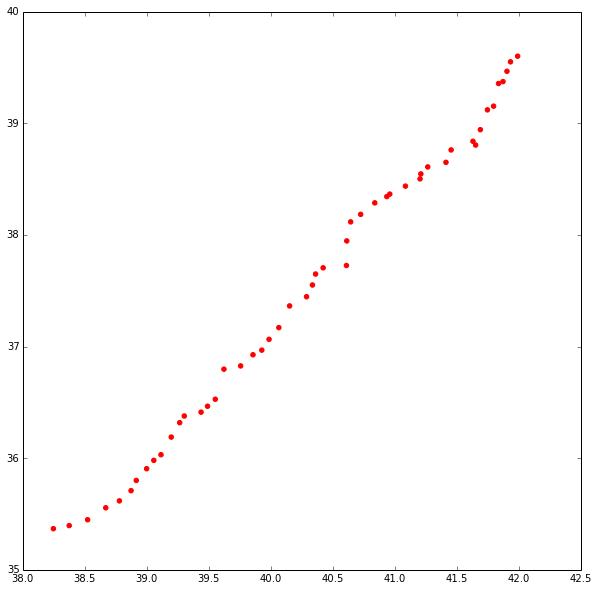

In [47]:
fig, axes = plt.subplots(figsize = (10,10))
plt.scatter(Y_meas[0], Y_meas[1], color = 'red')


Both Distributions have to be merged together $\mu_\text{new}=\mu_\text{0}+\mu_\text{move}$ is the new mean and $\sigma^2_\text{new}=\sigma^2_\text{0}+\sigma^2_\text{move}$ is the new variance.

Now both Distributions have to be merged together $\sigma^2_\text{new}=\cfrac{1}{\cfrac{1}{\sigma^2_\text{old}}+\cfrac{1}{\sigma^2_\text{Sensor}}}$ is the new variance and the new mean value is $\mu_\text{new}=\cfrac{\sigma^2_\text{Sensor} \cdot \mu_\text{old} + \sigma^2_\text{old} \cdot \mu_\text{Sensor}}{\sigma^2_\text{old}+\sigma^2_\text{Sensor}}$

Constant Velocity Model for Ego Motion

$$x_k= \left[ \matrix{ x \ y \ \dot x \ \dot y} \right] = \matrix{ \text{Position X} \ \text{Position Y} \ \text{Velocity in X} \ \text{Velocity in Y}}$$

# IMU SENSOR

Constant Velocity Model for Ego Motion

$$x_k= \left[ \matrix{ x \ y \ \dot x \ \dot y} \right] = \matrix{ \text{Position X} \ \text{Position Y} \ \text{Velocity in X} \ \text{Velocity in Y}}$$

(matrix([[0.],
        [0.],
        [0.],
        [0.]]), (4, 1))


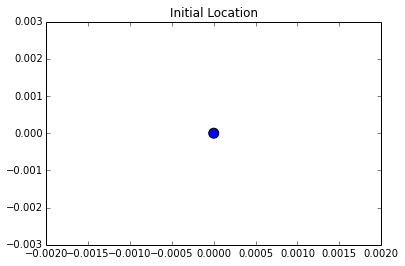

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

x = np.matrix([[0.0, 0.0, 0.0, 0.0]]).T
print(x, x.shape)
plt.scatter(float(x[0]),float(x[1]), s=100)
plt.title('Initial Location')

### Convariace matrix P

An uncertainty must be given for the initial state x0 . In the 1D case, the σ0 , now a matrix, defines an initial uncertainty for all states.

This matrix is ​​most likely to be changed during the filter passes. It is changed in both the Predict and Correct steps. If one is quite sure about the states at the beginning, one can use low values ​​here, if one does not know exactly how the values ​​of the state vector are, the covariance matrix should be Pinitialized with very large values ​​(1 million or so) to allow the filter to converge relatively quickly (find the right values ​​based on the measurements).

(array([[1000.,    0.,    0.,    0.],
       [   0., 1000.,    0.,    0.],
       [   0.,    0., 1000.,    0.],
       [   0.,    0.,    0., 1000.]]), (4, 4))


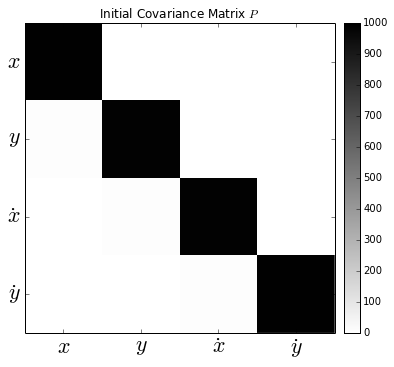

In [52]:
P = np.diag([1000.0, 1000.0, 1000.0, 1000.0])
print(P, P.shape)

fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Initial Covariance Matrix $P$')
ylocs, ylabels = plt.yticks()
plt.yticks(np.arange(7))
# 
plt.yticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)
xlocs, xlabels = plt.xticks()
# 
plt.xticks(np.arange(7))

plt.xticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

plt.xlim([-0.5,3.5])
plt.ylim([3.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax);

The core of the filter, however, is the following definition,, which we would set up yourself only with great understanding of the physical context. This is not easy for many real problems. For our simple example (in-plane motion), the physics behind it comes from the smooth motion. The position results in xt + 1= x˙t⋅ t + xt and in velocity x˙t + 1= x˙t . For the state vector shown above, the dynamics in matrix notation is as follows:

This states "where" the state vector moves from one calculation step to the next within dt . This dynamic model is also called a "constant velocity" model because it assumes that the velocity remains constant during a filter's calculation step.

As an example, only the first line is written out, which calculates the position after a calculation step with the duration dt .

This states "where" the state vector moves from one calculation step to the next within dt . This dynamic model is also called a "constant velocity" model because it assumes that the velocity remains constant during a filter's calculation step.

As an example, only the first line is written out, which calculates the position after a calculation step with the duration dt .

$xt + 1= xt+ dt ⋅ x˙t$

### Measurement Matrix $H$
The filter must also be told what is measured and how it relates to the state vector. In the example of the vehicle, what enters a tunnel, only the speed, not the position! The values ​​can be measured directly with the factor 1 (ie the velocity is measured directly in the correct unit), which is why in only 1.0 is set to the appropriate position.H

In [54]:
dt = 0.1


A = np.matrix([[1.0, 0.0, dt, 0.0],
              [0.0, 1.0, 0.0, dt],
              [0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
print(A, A.shape)


# 
# 


H = np.matrix([[0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
print(H, H.shape)

(matrix([[1. , 0. , 0.1, 0. ],
        [0. , 1. , 0. , 0.1],
        [0. , 0. , 1. , 0. ],
        [0. , 0. , 0. , 1. ]]), (4, 4))
(matrix([[0., 0., 1., 0.],
        [0., 0., 0., 1.]]), (2, 4))


### Measurement Noise Covariance $R$
Measurement noise covariance matrix R As in the one-dimensional case the variance , a measurement uncertainty must also be stated here.σ0

This measurement uncertainty indicates how much one trusts the measured values ​​of the sensors. Since we measure only $\dot x$ and $\dot y$ , this is a 2 × 2 matrix. If the sensor is very accurate, small values ​​should be used here. If the sensor is relatively inaccurate, large values ​​should be used here for $\dot x$, $\dot y$

In [55]:
ra = 10.0**2

R = np.matrix([[ra, 0.0],
              [0.0, ra]])
print(R, R.shape)

(matrix([[100.,   0.],
        [  0., 100.]]), (2, 2))


We have our IMU data with position, velocity and acceleration. So our $X$ variable is:

\begin{equation}
X(t) = \begin{pmatrix}
x(t) \\ \dot{x}(t) \\ \ddot{x}(t)
\end{pmatrix}
\end{equation}

 We assume for small step times, $dt << 1$, that the velocity is constant, so that we can model the variable state as:

\begin{equation}
\begin{cases}
\ddot{x}(t+1) =  \dot{v}_{cmd}(t)\\
\dot{x}(t+1)  = \dot{x}(t) + \ddot{x}(t)dt \\ 
x(t+1)  = x(t) + \dot{x}(t)dt + \frac{1}{2}\ddot{x}dt^2
\end{cases}
\end{equation}

where $v_{cmd}$ is the velocity command to control the robot that we send.


We can predict the evolution of the state variable $X$ for time (t+1) using these dynamical equations. We can write these equations in matrix notation:

\begin{equation}
X(t+1) = AX(t) + Bu(t)
\end{equation}

where $A$ is a matrix that determines the dynamics of the model in the absent of input control $u(t)$, in our case


\begin{equation}
A = 
\begin{pmatrix}
1 & dt & dt^2/2 \\
0 & 1  & dt     \\
0 & 0  & 0
\end{pmatrix}
\end{equation}

and $B$ is a matrix that describes how the control input $u(t)$ affects the state variable $X(t)$, in our case:

\begin{equation}
B = 
\begin{pmatrix}
0 \\
0     \\
1 
\end{pmatrix}
\end{equation}

Finally, $u(t) = \dot{v}_{cmd}$ is described by the velocity command to the robot.

In [77]:
def getDynamicalMatrices(dt):
    A = np.array([[1, dt, dt**2/2],
                  [0, 1,  dt     ],
                  [0, 0,  0     ]])
    
    B = np.array([[0],
                  [0],
                  [1]  ])
    return A, B


dt = 0.01
A, B = getDynamicalMatrices(dt)
print(A)
print(A.shape)
print("")
print(B)
print(B.shape)

u = 0

[[1.e+00 1.e-02 5.e-05]
 [0.e+00 1.e+00 1.e-02]
 [0.e+00 0.e+00 0.e+00]]
(3, 3)

[[0]
 [0]
 [1]]
(3, 1)


The covariance matrix $P$ will change over time. It is changed in both the prediction and update steps. If these values are not exactly known, they should be initialized with very large values to allow the filter to converge faster based on the measurements.

In [78]:
P = np.diag([1000.0]*3)
print(P)

[[1000.    0.    0.]
 [   0. 1000.    0.]
 [   0.    0. 1000.]]


## Sensor data

Our sensor measure the state of $X$ given the following equation:

\begin{equation}
Y(t) = HX(t)
\end{equation}

In particular, our sensor measures the position velocity and acceleration, 

\begin{equation}
Y(t) = \begin{pmatrix}
x'(t) \\ \dot{x}'(t) \\ \ddot{x}'(t)
\end{pmatrix}
\end{equation}

so that in this case we assume that H is a matrix $3x3$:

\begin{equation}
H = \begin{pmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{pmatrix}
\end{equation}

In [166]:
H = np.eye(3)
print(H)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


### Measurement Noise Covariance $R$
The Measurement noise covariance matrix R represents the uncertainty of the measured values from the sensor. Since we measure position, velocity and acceleration, this is a $3x3$ matrix. If the sensor is very accurate, the matrix should small values. If the sensor is inaccurate, large values represent uncertainty. 

In [155]:
R = 10*np.eye(3)
print(R)

[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0. 10.]]


# Kalman filter
Consist in two steps:
### Predict step
\begin{equation}
\begin{cases}
X(t) = AX(t-1) + Bu(t-1) \\
P(t) = AP(t-1)A^T+Q(t-1)
\end{cases}
\end{equation}

### Update
\begin{equation}
\begin{cases}
V(t) = Y(t) - HX(t) \\ 
S(t) = HP(t)H^T + R    \\
K(t) = P(t) H^T S^{-1}(t) \\
X(t) = X(t) + K(t)V(t)  \\
P(t) = P(t) - K(t)S(t)K^T(t)
\end{cases}
\end{equation}

In [177]:
def kf_predict(X, P, A, Q, B, U):
    X = np.dot(A, X) + np.dot(B, U)
    P = np.dot(A, np.dot(P, A.T)) + Q
    return(X,P) 


X = np.array([[0,0.05,0]]).T  # [m, m/s, m/s2]

covariance_sim_X = 0.001       # covariance of white noise in X
covariance_sim_Y = 0.01       # covariance of white noise in X


Q = covariance_sim_X * np.eye(X_0.shape[0])

N_iter = 100
Y_time = np.zeros([N_iter, 3, 1])



for i in range(N_iter):
    u = 0
    if i > 20 and i < 40:
        u = 0.1
        
    X, P = kf_predict(X, P, A, Q, B, u)
    Y = np.dot(H,X) + covariance_sim_Y * np.random.randn(3,1)
    Y_time[i] = Y

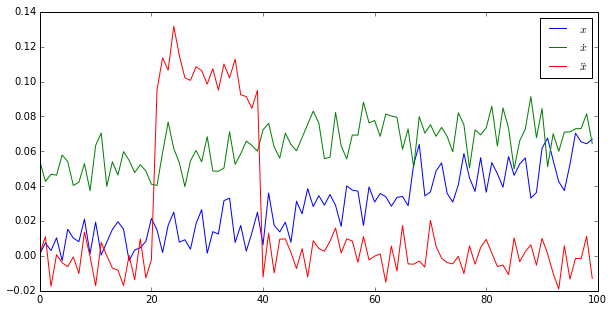

In [178]:
fig, axes = plt.subplots(figsize = (10,5))
axes.plot(Y_time[:,0,0], color = 'blue',  label = r'$x$')
axes.plot(Y_time[:,1,0], color = 'green', label = r'$\dot{x}$')
axes.plot(Y_time[:,2,0], color = 'red',   label = r'$\ddot{x}$')
plt.legend()

In [179]:
def kf_update(X, P, Y, H, R):
    IM = np.dot(H, X)
    IS = R + np.dot(H, np.dot(P, H.T))
    K = np.dot(P, np.dot(H.T, np.linalg.inv(IS)))
    X = X + np.dot(K, (Y-IM))
    P = P - np.dot(K, np.dot(IS, K.T))
    LH = gauss_pdf(Y, IM, IS)
    return (X,P,K,IM,IS,LH) 


X = np.array([[0,0.05,0]]).T  # [m, m/s, m/s2]
R = covariance_sim_Y*np.eye(3)


X_time = np.zeros([N_iter, 3, 1])

for i in range(N_iter):
    u = 0
    if i > 20 and i < 40:
        u = 0.1
        
        
    (X, P) = kf_predict(X, P, A, Q, B, u)
    (X, P, K, IM, IS, LH) = kf_update(X, P, Y_time[i], H, R)
    
    X_time[i] = X

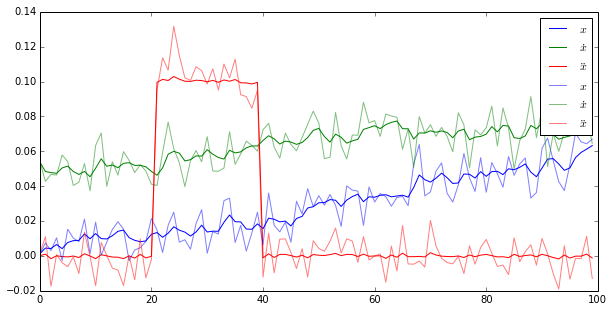

In [180]:
fig, axes = plt.subplots(figsize = (10,5))
axes.plot(X_time[:,0,0], color = 'blue',  label = r'$x$')
axes.plot(X_time[:,1,0], color = 'green', label = r'$\dot{x}$')
axes.plot(X_time[:,2,0], color = 'red',   label = r'$\ddot{x}$')
plt.legend()

axes.plot(Y_time[:,0,0], color = 'blue',  label = r'$x$', alpha = 0.5)
axes.plot(Y_time[:,1,0], color = 'green', label = r'$\dot{x}$', alpha = 0.5)
axes.plot(Y_time[:,2,0], color = 'red',   label = r'$\ddot{x}$', alpha = 0.5)
plt.legend()

# Teensy and BNO055 IMU sensor

In [1]:
import serial

In [3]:
import numpy as np
import matplotlib.pyplot as plt

m = 100
n = 100
matrix = np.random.normal(0,1,m*n).reshape(m,n)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(0,100):
    ax.clear()
    ax.plot(matrix[i,:])
    fig.canvas.draw()